In [1]:
# Importing various libraries for later use in the project
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier


import csv
from bs4 import BeautifulSoup

import requests
import sys
import re

import warnings

# Setting up data import limits for speeding up the coding and testing process
fund_house_count=10   # number of top fund houses to be analyzed
f_scheme_count=1500    # Maximum number of fund schemes to be analyzed

# Defining source for webscaping financial data
money_control_root = 'http://www.moneycontrol.com'

#to ignore A value is trying to be set on a copy of a slice from a DataFrame Warning
pd.options.mode.chained_assignment = None  # default='warn'

#to ignore DeprecationWarning
np.warnings.filterwarnings('ignore')
import sklearn.cross_validation

In [2]:
# Get top mutual fund houses with the highest Assets under Management from Money Control
markup = requests.get(money_control_root + '/mutual-funds/amc-assets-monitor').text

# make the soup
soup = BeautifulSoup(markup, "lxml")

# the table that contains the required data
table = soup.find_all('table', attrs = {"class": "tblfund1"})[0]

# get the first ten rows in this table, excluding
# the first row as it has only header information
rows = table.find_all('tr')[1:fund_house_count]


# Fund Family and Assets under Management (Rs. Cr.) for the top 10 mutual fund families
fund_fam = []
for r in rows:
    ff_dict = {
        'fund_fam_name': unicode( r.contents[1].a.string ),
        'fund_fam_url' : unicode( money_control_root + r.contents[1].a.attrs['href'] ),
        'fund_fam_aum' : unicode( r.contents[5].string ),
        'fund_fam_sc' : unicode( money_control_root + r.contents[1].a.attrs['href'] ).split('/')[-1]
    }
    
    fund_fam.append( ff_dict )

In [3]:
print( fund_fam )

[{'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'fund_fam_name': u'HDFC Mutual Fund', 'fund_fam_sc': u'HD', 'fund_fam_aum': u'342,291'}, {'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/PI', 'fund_fam_name': u'ICICI Prudential Mutual Fund', 'fund_fam_sc': u'PI', 'fund_fam_aum': u'320,793'}, {'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/SB', 'fund_fam_name': u'SBI Mutual Fund', 'fund_fam_sc': u'SB', 'fund_fam_aum': u'283,807'}, {'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/BS', 'fund_fam_name': u'Aditya Birla Sun Life Mutual Fund', 'fund_fam_sc': u'BS', 'fund_fam_aum': u'246,480'}, {'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/RC', 'fund_fam_name': u'Reliance Mutual Fund', 'fund_fam_sc': u'RC', 'fund_fam_aum': u'233,617'}, {'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/UT', 'fund_fam_name': u'UTI Mutual Fund', 'fund_fam_sc': u'UT', '

In [4]:
# For each fund family, get a list of all fund schemes along with other details
f_schemes = []
for fund in fund_fam:
    
    markup = requests.get( fund['fund_fam_url'] ).text

    soup = BeautifulSoup(markup, "lxml")

    rows = soup.select('.FL.MT10.boxBg table tr')[1:-1]
    
    for r in rows:
        data_elems      = r.find_all('td')
    
        cat_name   = ''
        sch_aum      = ''
        cat_url    = ''
        
        try:
            cat_name   = unicode( data_elems[2].a.string )
            cat_url    = money_control_root + data_elems[2].a.attrs['href']
            
        except AttributeError:
            cat_name   = u'None'
            cat_url    = u'None'
    
        try:
            sch_aum = unicode( data_elems[5].string )
        except AttributeError:
            sch_aum = u'None'

        f_scheme_dict    = {
            'fund_fam_name'      : fund['fund_fam_name'],
            'fund_fam_url'       : fund['fund_fam_url' ],
            'fund_fam_aum'       : fund['fund_fam_aum' ],
            'fund_fam_sc' : fund['fund_fam_sc'],
            'sch_name'           : unicode( data_elems[0].a.string ),
            'sch_url'            : money_control_root + data_elems[0].a.attrs['href'],
            'crisil_rating'         : unicode( data_elems[1].a.string ),
            'category'              : cat_name,
            'cat_url'          : cat_url,
            'latest_nav'            : unicode( data_elems[3].string ),
            '1yr_return'            : u'None' if unicode( data_elems[4].string ) == u'--' else unicode( data_elems[4].string ),
            'sch_aum'            : sch_aum
        }

        f_schemes.append( f_scheme_dict )

In [5]:
print( len( f_schemes ), '\n\n', f_schemes[:1])

(1406, '\n\n', [{'fund_fam_sc': u'HD', 'latest_nav': u'22.48', 'fund_fam_name': u'HDFC Mutual Fund', 'sch_aum': u'2.63', 'category': u'Arbitrage Fund', 'sch_name': u'HDFC Arbitrage Fund - Direct (G)', 'fund_fam_aum': u'342,291', 'sch_url': 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/MHD1171', 'cat_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-fund.html', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', '1yr_return': u'6.6', 'crisil_rating': u'Rank 3'}])


In [6]:
f_schemes = f_schemes[:f_scheme_count]


In [7]:
# Extract data for each of the Mutual Fund Schemes

for idx, scheme in enumerate(f_schemes):
    try:
        # Read the page at the URL for each scheme
        markup = requests.get(scheme['sch_url']).text
        soup = BeautifulSoup(markup, "lxml")

        # Riskometer (Risk Rating)
        scheme['sch_text_risk'] = unicode(soup.select_one(".status").text)

        # Fund Category
        scheme['sch_fund_type'] = unicode(soup.select_one(".sub_category_text").text)
        
        # Scheme Plan and Scheme Option
        sch_plan_option_data    = [unicode( x.string ).strip() for x in soup.select('#planname_frm .FL span')]

        [scheme['sch_plan'],
        scheme['sch_option'] ] = sch_plan_option_data if sch_plan_option_data else [u'None', u'None']


        returns_table = soup.find('table',{'class':'mctable1'})
        rows = returns_table.findAll('tr')

        for row in rows:
            row_attrs = [x for x in row.children if unicode(x).strip()]

            row_name  = unicode(row_attrs[0].string).strip().lower()

            # Setting up fund returns for different durations
            if row_name == '1 week':
                    scheme['f_return_1wk']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1wk']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1wk']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 month':
                    scheme['f_return_1m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 month':
                    scheme['f_return_3m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_3m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_3m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '6 month':
                    scheme['f_return_6m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_6m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_6m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 year':
                    scheme['f_return_1yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '2 year':
                    scheme['f_return_2yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_2yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_2yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 year':
                    scheme['f_return_3yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_3yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_3yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '5 year':
                    scheme['f_return_5yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_5yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_5yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '10 year':
                    scheme['f_return_10y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_10y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )

            if row_name == 'since inception':
                    scheme['f_return_si']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )

        # Print every 200th scheme, to verify that extraction is running fine
        if idx % 200 == 0:
            print( 'Scheme # {0}\n{1}\n\n\n'.format(idx, scheme) )
        else:
            print idx, ' ',

    except:
        pass


Scheme # 0
{'rank_in_cat_6m': u'11/21', 'f_return_1m': u'0.69%', 'cat_ret_avg_2yr': u'6.50%', 'f_return_10y': u'-', 'f_return_3yr': u'20.75%', 'rank_in_cat_2yr': u'15/18', 'f_return_5yr': u'39.49%', 'f_return_1yr': u'6.62%', 'fund_fam_aum': u'342,291', 'rank_in_cat_1wk': u'22/24', 'cat_ret_avg_6m': u'3.36%', 'latest_nav': u'22.48', 'cat_ret_avg_10y': u'-', 'cat_ret_avg_5yr': u'7.12%', 'sch_plan': u'None', 'sch_text_risk': u'Moderately Low', 'cat_ret_avg_1yr': u'6.47%', 'rank_in_cat_1m': u'9/24', '1yr_return': u'6.6', 'crisil_rating': u'Rank 3', 'f_return_3m': u'2.03%', 'fund_fam_sc': u'HD', 'cat_ret_avg_3yr': u'6.58%', 'sch_fund_type': u'Arbitrage Fund', 'cat_ret_avg_1m': u'0.66%', 'category': u'Arbitrage Fund', 'sch_name': u'HDFC Arbitrage Fund - Direct (G)', 'f_return_1wk': u'-0.05%', 'sch_option': u'None', 'rank_in_cat_1yr': u'13/19', 'f_return_si': u'57.13%', 'rank_in_cat_5yr': u'9/11', 'fund_fam_name': u'HDFC Mutual Fund', 'rank_in_cat_3yr': u'14/17', 'sch_aum': u'2.63', 'cat_ret_

In [8]:

#Save the collected data to a csv file.

out_path= "./top_schemes.csv"
out_file = open(out_path, 'wb')

fieldnames = sorted(list(set(k for d in f_schemes for k in d)))
writer = csv.DictWriter(out_file, fieldnames=fieldnames, dialect='excel')

writer.writeheader() 
for row in f_schemes:
    writer.writerow(row)
out_file.close()


In [9]:
# Data Engineering to prepare the data for ML

def encode_risk(text_risk):
    '''
    Method to convert risk text to a numerical attribute
    The higher the risk, the lower the score!

    '''
    text_risk = unicode(text_risk.upper())
    risk=0
    if text_risk == u'HIGH': risk = 1
    if text_risk == u'MODERATELY HIGH': risk = 2
    if text_risk == u'MODERATE': risk = 3
    if text_risk == u'MODERATELY LOW': risk = 4
    if text_risk == u'LOW': risk = 5
     
    return risk



def conv_numeric( text ):
    '''
    Method to convert numerical features that appear as strings or unicode strings into numbers
    '''

    try:
        return float( re.sub(
            '(Rs[ ]*\.)|[^\d|.|-]|(Rank[ ]*)',
            '',
            text,
            flags = re.IGNORECASE
        ) )
    except:
        return 0

    
    
def conv_rank (rank_in_cat):
    '''
    Method to convert rank in category to numeric value between 0 to 1
    '''
    pos = rank_in_cat.rfind('/')
    rank=0
    # Convert Rank within Categoty to numeric field between 0 to 1, 0 lowest rank, 1 higher rank
    try: 
        rank = 1 - (float(rank_in_cat[:pos]) / float(rank_in_cat[pos+1:]))
    except:
        rank = 0

    return rank


In [10]:

# Initialize a list to store metrics for risk
for idx, scheme in enumerate( f_schemes ):
    ##
    # Step 1: Convert numerical features appearing as text to numerical features
    #         1.a: Encode risk text to a numerical representation of risk.
    #              Highest risk gets the lowest score, lowest risk gets the highest score
    #              in case of an exception (risk data not available), highest risk is assigned
    #
    #         1.b: Convert numbers formatted with commas or currency or rating description to just numbers
    ##
    
    # Convert scheme risk text to a numerical attribute
    try:
        f_schemes[idx]['num_risk_rating']      = encode_risk(scheme['sch_text_risk'])
    except:
        f_schemes[idx]['num_risk_rating'] = 0
    
    # Convert metrics to numerical features
    variables1 = ['crisil_rating','fund_fam_aum','sch_aum','f_return_1wk','f_return_1m','f_return_3m','f_return_6m',
                 'f_return_1yr','f_return_2yr','f_return_3yr','f_return_5yr','f_return_si','latest_nav',
                 'cat_ret_avg_1wk','cat_ret_avg_1m','cat_ret_avg_3m','cat_ret_avg_6m','cat_ret_avg_1yr','cat_ret_avg_2yr',
                 'cat_ret_avg_3yr','cat_ret_avg_5yr']
    
    for i in variables1:
        out_var = 'num_'+i
        try:
            f_schemes[idx][out_var] = conv_numeric(scheme[i])
        except:
            f_schemes[idx][out_var]=0
            
    
    ##
    # Step 2: Calculate additional risk metrics - the fetched risk rating is based on MPT Statistics
    #         which is already a sound measurement. Hence, we devise and incorporate more measures
    #         such as:
    ##
    
    #normalize risk on scale of 0 to 1
    f_schemes[idx]['cstm_risk_rating'] = float(f_schemes[idx]['num_risk_rating']) / 5
    
    
    # Score between 0 and 1 based on CRISIL rating

    f_schemes[idx]['cstm_crisil']  = float(f_schemes[idx]['num_crisil_rating']) / 5

    
    # Score between 0 and 1 based on AUM allocation to the scheme compared to other schemes in the fund family
    try:
        f_schemes[idx]['cstm_alloc'] = float( f_schemes[idx]['num_sch_aum'] ) / ( f_schemes[idx]['num_fund_fam_aum'] - f_schemes[idx]['num_sch_aum'] )
    except:
        f_schemes[idx]['cstm_alloc'] = 0
    
    
    # Convert Rank within Categoty to numeric field between 0 to 1, 0 lowest rank, 1 higher rank
    variables2 = ['1wk','1m','3m','6m','1yr','2yr','3yr','5yr']
    for i in variables2:
        in_var = 'rank_in_cat_'+i
        out_var = 'cstm_diff_'+i
        try:
            f_schemes[idx][out_var] = conv_rank(scheme[in_var])
        except:
            f_schemes[idx][out_var]=0
    
       
    # Initialize a set of lists to contain class labels based on time frame
    norm_scores_1wk = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1wk']
    ]
    
    norm_scores_1m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1m']
    ]
    
    norm_scores_3m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_3m']
    ]
    
    norm_scores_6m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_6m']
    ]
    
    norm_scores_1yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1yr']
    ]
    
    norm_scores_2yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_2yr']
    ]
    
    norm_scores_3yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_3yr']
    ]
    
    norm_scores_5yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_5yr']
    ]
    

    ##
    # Calculate labels for each time frame based on calculated metrics
    ## 
    ##

    labels_1wk = round( float( sum(norm_scores_1wk ) ) / max( len( norm_scores_1wk ), 1 ) )
    labels_1m = round( float( sum(norm_scores_1m ) ) / max( len( norm_scores_1m ), 1 ) )
    labels_3m = round( float( sum(norm_scores_3m ) ) / max( len( norm_scores_3m ), 1 ) )
    labels_6m = round( float( sum(norm_scores_6m ) ) / max( len( norm_scores_6m ), 1 ) )
    labels_1yr = round( float( sum(norm_scores_1yr ) ) / max( len( norm_scores_1yr ), 1 ) )
    labels_2yr = round( float( sum(norm_scores_2yr ) ) / max( len( norm_scores_2yr ), 1 ) )
    labels_3yr = round( float( sum(norm_scores_3yr ) ) / max( len( norm_scores_3yr ), 1 ) )
    labels_5yr = round( float( sum(norm_scores_5yr ) ) / max( len( norm_scores_5yr ), 1 ) )
    

    # Store the labels for each time frame along with scheme details
    f_schemes[idx]['calc_label_1wk'] = labels_1wk
    f_schemes[idx]['calc_label_1m'] = labels_1m
    f_schemes[idx]['calc_label_3m'] = labels_3m
    f_schemes[idx]['calc_label_6m'] = labels_6m
    f_schemes[idx]['calc_label_1yr'] = labels_1yr
    f_schemes[idx]['calc_label_2yr'] = labels_2yr
    f_schemes[idx]['calc_label_3yr'] = labels_3yr
    f_schemes[idx]['calc_label_5yr'] = labels_5yr
    
    

809.0


In [11]:
 f_schemes[:2]

[{'1yr_return': u'6.6',
  'calc_label_1m': 1.0,
  'calc_label_1wk': 0.0,
  'calc_label_1yr': 0.0,
  'calc_label_2yr': 0.0,
  'calc_label_3m': 0.0,
  'calc_label_3yr': 0.0,
  'calc_label_5yr': 0.0,
  'calc_label_6m': 0.0,
  'cat_ret_avg_10y': u'-',
  'cat_ret_avg_1m': u'0.66%',
  'cat_ret_avg_1wk': u'-0.03%',
  'cat_ret_avg_1yr': u'6.47%',
  'cat_ret_avg_2yr': u'6.50%',
  'cat_ret_avg_3m': u'1.97%',
  'cat_ret_avg_3yr': u'6.58%',
  'cat_ret_avg_5yr': u'7.12%',
  'cat_ret_avg_6m': u'3.36%',
  'cat_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-fund.html',
  'category': u'Arbitrage Fund',
  'crisil_rating': u'Rank 3',
  'cstm_alloc': 7.683579783911443e-06,
  'cstm_crisil': 0.6,
  'cstm_diff_1m': 0.625,
  'cstm_diff_1wk': 0.08333333333333337,
  'cstm_diff_1yr': 0.3157894736842105,
  'cstm_diff_2yr': 0.16666666666666663,
  'cstm_diff_3m': 0.5833333333333333,
  'cstm_diff_3yr': 0.17647058823529416,
  'cstm_diff_5yr': 0.18181818181818177,
  'cstm_diff_6m

In [12]:
##
# Create target values for each time frame
##
Yp_1wk = np.array( [scheme['calc_label_1wk'] for scheme in f_schemes] )
Yp_1m = np.array( [scheme['calc_label_1m'] for scheme in f_schemes] )
Yp_3m = np.array( [scheme['calc_label_3m'] for scheme in f_schemes] )
Yp_6m = np.array( [scheme['calc_label_6m'] for scheme in f_schemes] )
Yp_1yr = np.array( [scheme['calc_label_1yr'] for scheme in f_schemes] )
Yp_2yr = np.array( [scheme['calc_label_2yr'] for scheme in f_schemes] )
Yp_3yr = np.array( [scheme['calc_label_3yr'] for scheme in f_schemes] )
Yp_5yr = np.array( [scheme['calc_label_5yr'] for scheme in f_schemes] )


In [13]:
##
# Create feature vectors for each time frame
##
Xv_1wk = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1wk']           if scheme['num_f_return_1wk'] else 0,
            scheme['num_cat_ret_avg_1wk']        if scheme['num_cat_ret_avg_1wk'] else 0
        ]
        for scheme in f_schemes
    ]
)

Xv_1m = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1m']           if scheme['num_f_return_1m'] else 0,
            scheme['num_cat_ret_avg_1m']        if scheme['num_cat_ret_avg_1m'] else 0
        ]
        for scheme in f_schemes
    ]
)

Xv_3m = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_3m']           if scheme['num_f_return_3m'] else 0,
            scheme['num_cat_ret_avg_3m']        if scheme['num_cat_ret_avg_3m'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_6m = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_6m']           if scheme['num_f_return_6m'] else 0,
            scheme['num_cat_ret_avg_6m']        if scheme['num_cat_ret_avg_6m'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_1yr = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1yr']           if scheme['num_f_return_1yr'] else 0,
            scheme['num_cat_ret_avg_1yr']        if scheme['num_cat_ret_avg_1yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_2yr = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_2yr']           if scheme['num_f_return_2yr'] else 0,
            scheme['num_cat_ret_avg_2yr']        if scheme['num_cat_ret_avg_2yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_3yr = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_3yr']           if scheme['num_f_return_3yr'] else 0,
            scheme['num_cat_ret_avg_3yr']        if scheme['num_cat_ret_avg_3yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_5yr = np.array(
    [
        [
            scheme['num_risk_rating']           if scheme['num_risk_rating'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_5yr']           if scheme['num_f_return_5yr'] else 0,
            scheme['num_cat_ret_avg_5yr']        if scheme['num_cat_ret_avg_5yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)



# Handle NaNs using an Imputer
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

Xv_1wk = imp.fit_transform( Xv_1wk )
Xv_1m = imp.fit_transform( Xv_1m )
Xv_3m = imp.fit_transform( Xv_3m )
Xv_6m = imp.fit_transform( Xv_6m )
Xv_1yr = imp.fit_transform( Xv_1yr )
Xv_2yr = imp.fit_transform( Xv_2yr )
Xv_3yr = imp.fit_transform( Xv_3yr )
Xv_5yr = imp.fit_transform( Xv_5yr )


In [41]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.


tree_counts = range(1, 31)

# Define folds = N for N-fold cross-validation
fold_counts = 10

# Define a DF to store cross validation results
df_1wk = pd.DataFrame()
df_1m = pd.DataFrame()
df_3m = pd.DataFrame()
df_6m = pd.DataFrame()
df_1yr = pd.DataFrame()
df_2yr = pd.DataFrame()
df_3yr = pd.DataFrame()
df_5yr = pd.DataFrame()

df_1wk['tree_counts'] = [0]  * len( tree_counts )
df_1wk['scores']    = [[]] * len( tree_counts )

df_1m['tree_counts'] = [0]  * len( tree_counts )
df_1m['scores']    = [[]] * len( tree_counts )

df_3m['tree_counts'] = [0]  * len( tree_counts )
df_3m['scores']    = [[]] * len( tree_counts )

df_6m['tree_counts'] = [0]  * len( tree_counts )
df_6m['scores']    = [[]] * len( tree_counts )

df_1yr['tree_counts'] = [0]  * len( tree_counts )
df_1yr['scores']    = [[]] * len( tree_counts )

df_2yr['tree_counts'] = [0]  * len( tree_counts )
df_2yr['scores']    = [[]] * len( tree_counts )

df_3yr['tree_counts'] = [0]  * len( tree_counts )
df_3yr['scores']    = [[]] * len( tree_counts )

df_5yr['tree_counts'] = [0]  * len( tree_counts )
df_5yr['scores']    = [[]] * len( tree_counts )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in tree_counts:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1wk = sklearn.cross_validation.cross_val_score(forest, Xv_1wk[:1000, :], Yp_1wk[:1000], scoring = 'f1', cv = fold_counts)
    scores_1m = sklearn.cross_validation.cross_val_score(forest, Xv_1m[:1000, :], Yp_1m[:1000], scoring = 'f1', cv = fold_counts)
    scores_3m = sklearn.cross_validation.cross_val_score(forest, Xv_3m[:1000, :], Yp_3m[:1000], scoring = 'f1', cv = fold_counts)
    scores_6m = sklearn.cross_validation.cross_val_score(forest, Xv_6m[:1000, :], Yp_6m[:1000], scoring = 'f1', cv = fold_counts)
    scores_1yr = sklearn.cross_validation.cross_val_score(forest, Xv_1yr[:1000, :], Yp_1yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_2yr = sklearn.cross_validation.cross_val_score(forest, Xv_2yr[:1000, :], Yp_2yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_3yr = sklearn.cross_validation.cross_val_score(forest, Xv_3yr[:1000, :], Yp_3yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_5yr = sklearn.cross_validation.cross_val_score(forest, Xv_5yr[:1000, :], Yp_5yr[:1000], scoring = 'f1', cv = fold_counts)
    
    df_1wk['tree_counts'][ num - 1] = num
    df_1m['tree_counts'][ num - 1] = num
    df_3m['tree_counts'][ num - 1] = num
    df_6m['tree_counts'][ num - 1] = num
    df_1yr['tree_counts'][ num - 1] = num
    df_2yr['tree_counts'][ num - 1] = num
    df_3yr['tree_counts'][ num - 1] = num
    df_5yr['tree_counts'][ num - 1] = num
    
    df_1wk['scores'][ num - 1] = scores_1wk
    df_1m['scores'][ num - 1] = scores_1m
    df_3m['scores'][ num - 1] = scores_3m
    df_6m['scores'][ num - 1] = scores_6m
    df_1yr['scores'][ num - 1] = scores_1yr
    df_2yr['scores'][ num - 1] = scores_2yr
    df_3yr['scores'][ num - 1] = scores_3yr
    df_5yr['scores'][ num - 1] = scores_5yr


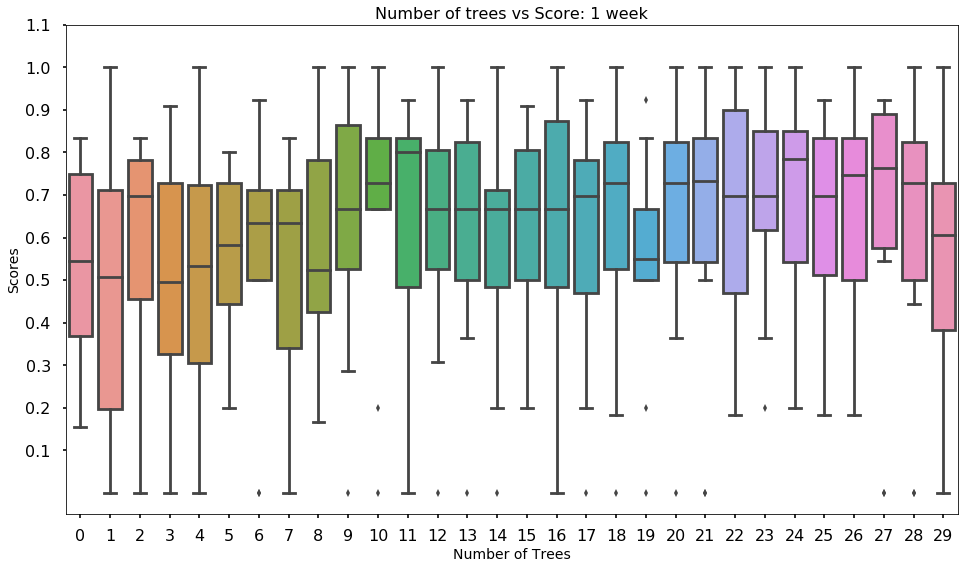

In [42]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_1wk.scores, names = df_1wk.tree_counts.values )
sns.boxplot(data  = df_1wk.scores)


plt.title(  "Number of trees vs Score: 1 week", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


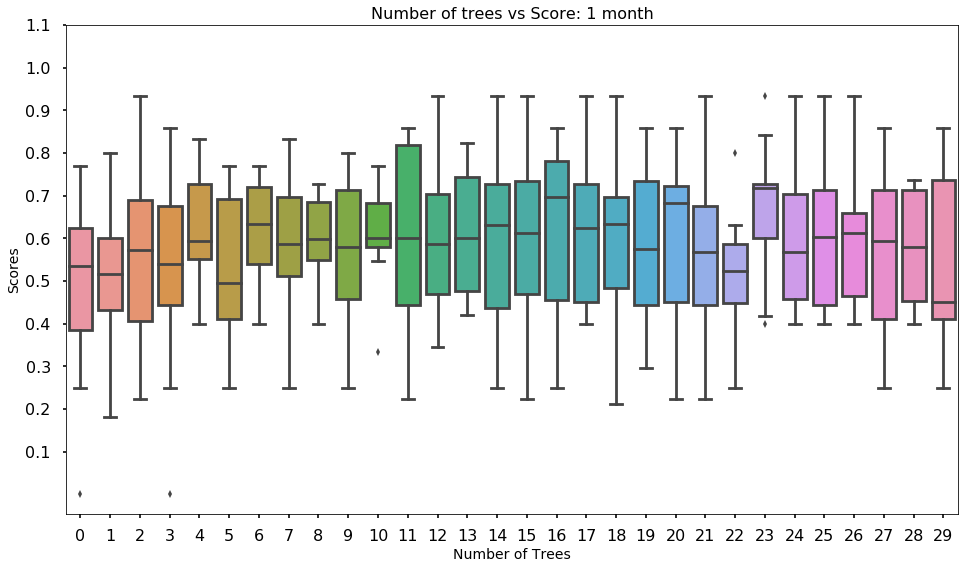

In [43]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_1m.scores, names = df_1m.tree_counts.values )
sns.boxplot(data  = df_1m.scores)

plt.title(  "Number of trees vs Score: 1 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


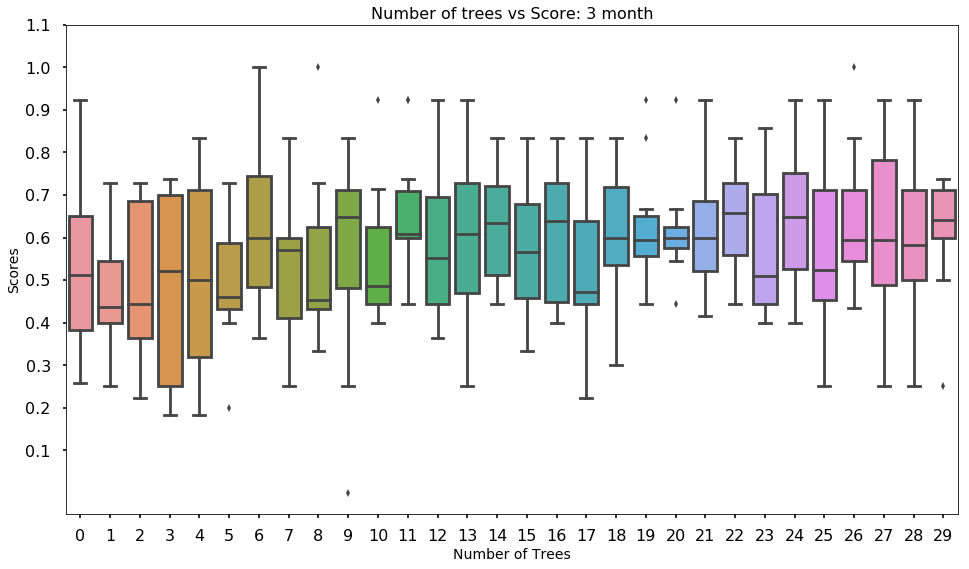

In [44]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_3m.scores)

plt.title(  "Number of trees vs Score: 3 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


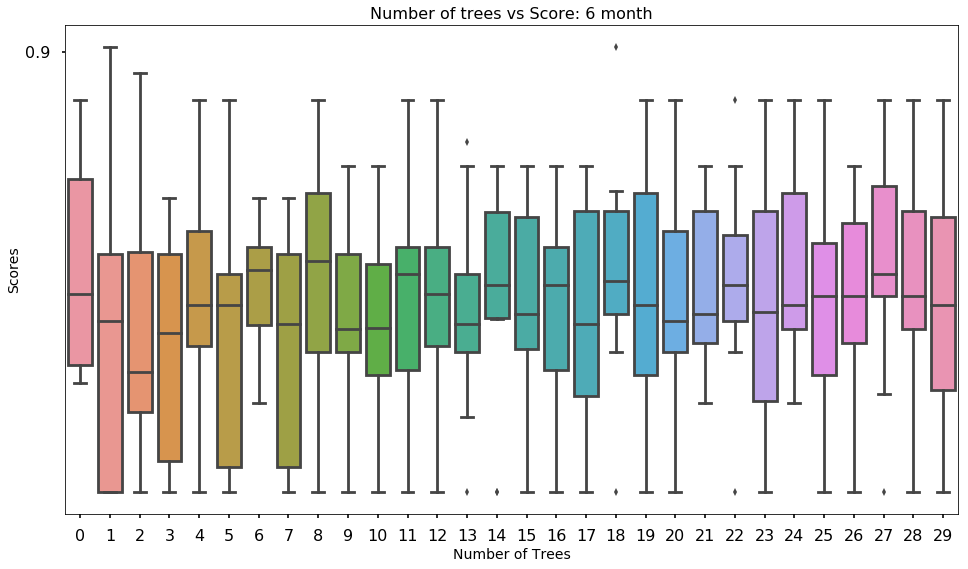

In [45]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot

sns.boxplot(data  = df_6m.scores)

plt.title(  "Number of trees vs Score: 6 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


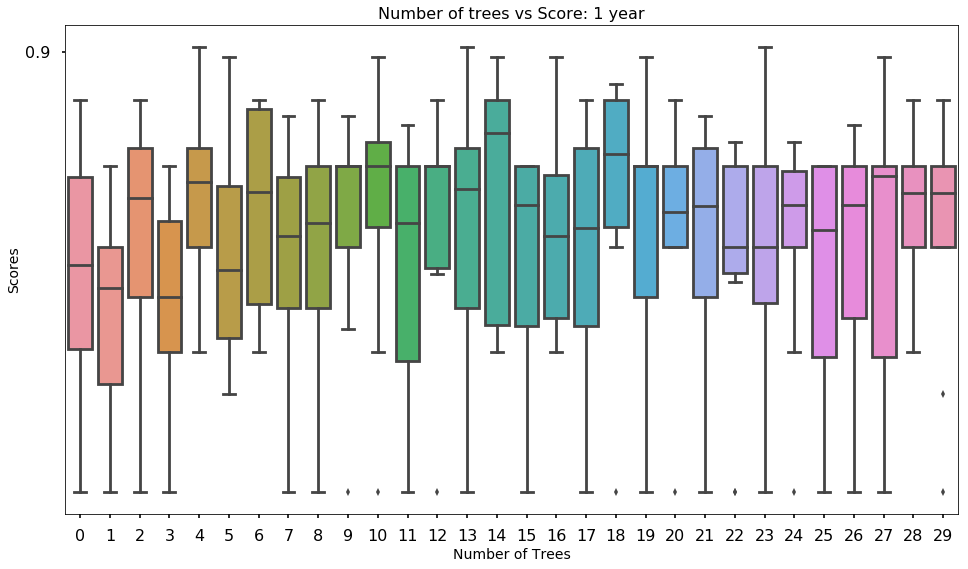

In [46]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_1yr.scores)

plt.title(  "Number of trees vs Score: 1 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


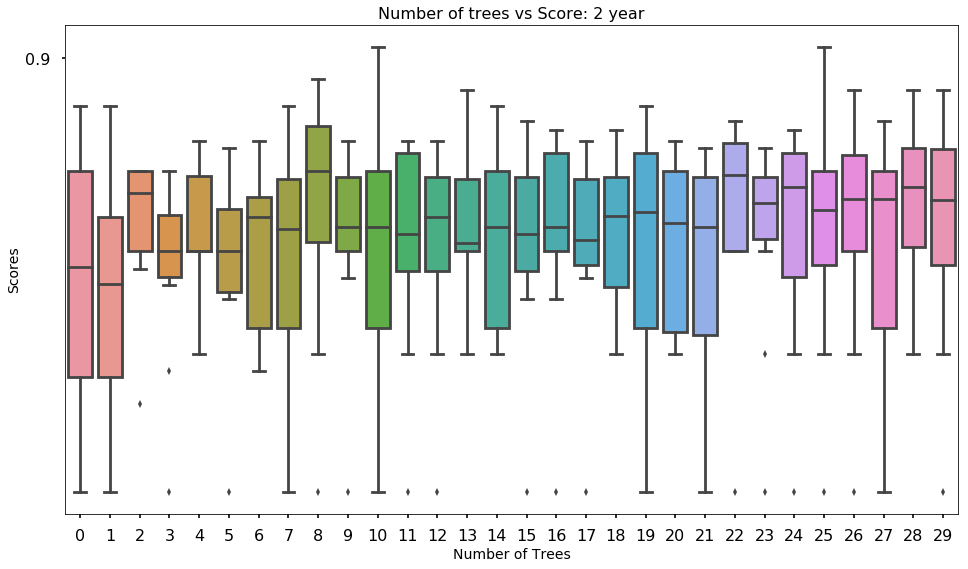

In [47]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_2yr.scores)

plt.title(  "Number of trees vs Score: 2 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


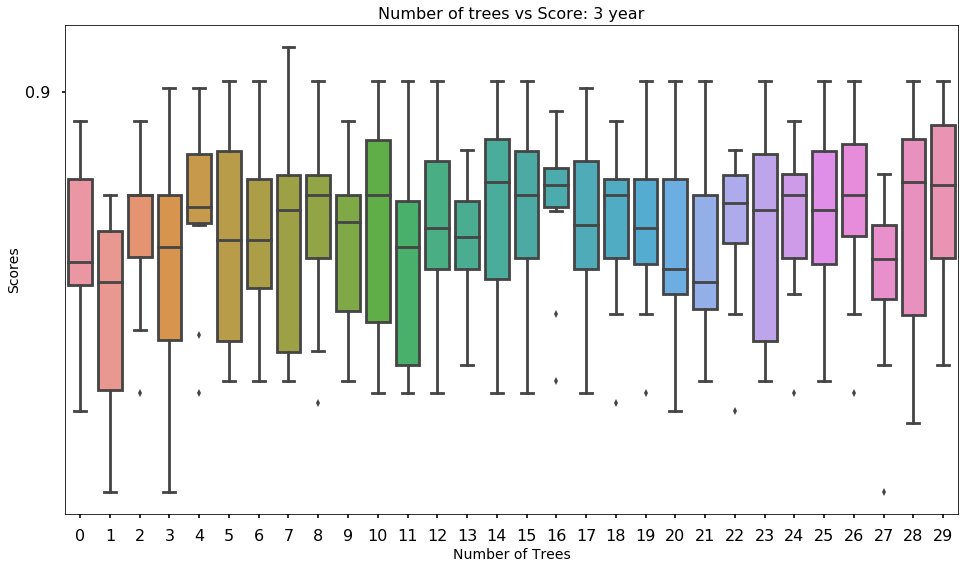

In [48]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_3yr.scores)

plt.title(  "Number of trees vs Score: 3 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


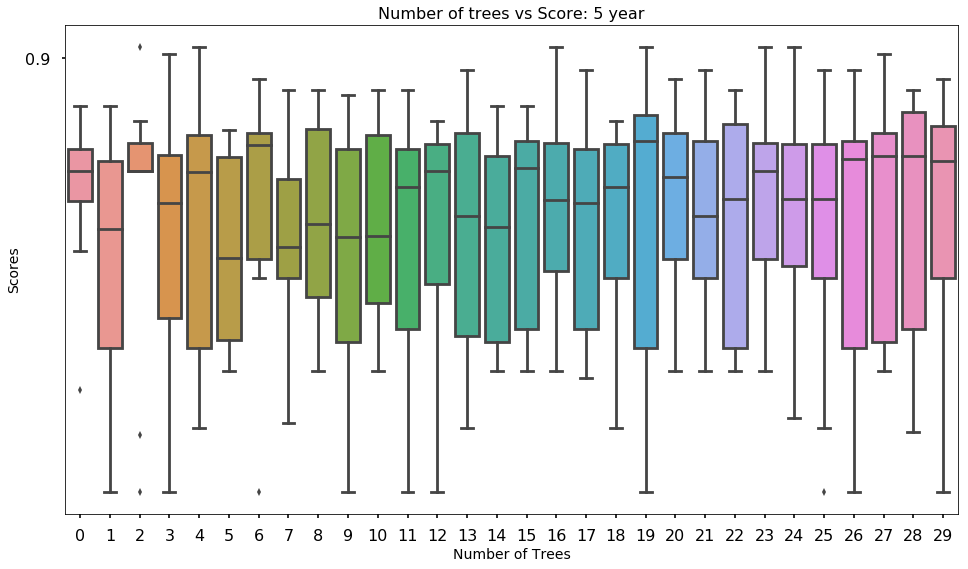

In [49]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_5yr.scores)

plt.title(  "Number of trees vs Score: 5 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


In [50]:
##
# 1 week:
##
# Train random forest classifier with the optimal 10 estimators
## 

clfe_1wk = sklearn.ensemble.RandomForestClassifier( n_estimators = 10)
clfe_1wk = clfe_1wk.fit( Xv_1wk[:1000, :], Yp_1wk[:1000] )


##
# 1 month:
##
# Train random forest classifier with the optimal 12 estimators
## 

clfe_1m = sklearn.ensemble.RandomForestClassifier( n_estimators = 12)
clfe_1m = clfe_1m.fit( Xv_1m[:1000, :], Yp_1m[:1000] )

##
# 3 month:
##
# Train random forest classifier with the optimal 6 estimators
## 
clfe_3m = sklearn.ensemble.RandomForestClassifier( n_estimators = 6)
clfe_3m = clfe_3m.fit( Xv_3m[:1000, :], Yp_3m[:1000] )

##
# 6 month:
##
# Train random forest classifier with the optimal 14 estimators
## 
clfe_6m = sklearn.ensemble.RandomForestClassifier( n_estimators = 14)
clfe_6m = clfe_6m.fit( Xv_6m[:1000, :], Yp_6m[:1000] )

##
# 1 year:
##
# Train random forest classifier with the optimal 4 estimators
## 
clfe_1yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 4)
clfe_1yr = clfe_1yr.fit( Xv_1yr[:1000, :], Yp_1yr[:1000] )

##
# 2 year:
##
# Train random forest classifier with the optimal 8 estimators
## 
clfe_2yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 8)
clfe_2yr = clfe_2yr.fit( Xv_2yr[:1000, :], Yp_2yr[:1000] )

##
# 3 year:
##
# Train random forest classifier with the optimal 4 estimators
## 
clfe_3yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 4)
clfe_3yr = clfe_3yr.fit( Xv_3yr[:1000, :], Yp_3yr[:1000] )

##
# 5 year:
##
# Train random forest classifier with the optimal 6 estimators
## 
clfe_5yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 6)
clfe_5yr = clfe_5yr.fit( Xv_5yr[:1000, :], Yp_5yr[:1000] )



# obtain the relative importance of the features 
imp_feature_1wk = clfe_1m.feature_importances_
imp_feature_1m = clfe_1m.feature_importances_
imp_feature_3m = clfe_3m.feature_importances_
imp_feature_6m = clfe_6m.feature_importances_
imp_feature_1yr = clfe_1yr.feature_importances_
imp_feature_2yr = clfe_2yr.feature_importances_
imp_feature_3yr = clfe_3yr.feature_importances_
imp_feature_5yr = clfe_5yr.feature_importances_

#get column names
columns = ['Scheme Risk',
            'CRISIL Rating',
            'Fund Family AUM',
            'Scheme AUM',
            'Latest NAV',
            'Fund Return',
            'Category Return'
          ]

# Diagnostics - Check relative importance of features
print imp_feature_1wk
print imp_feature_1m
print imp_feature_3m
print imp_feature_6m
print imp_feature_1yr
print imp_feature_2yr
print imp_feature_3yr
print imp_feature_5yr


# Plot feature importances for each time frame
index = np.arange( len(columns) - 1 )
bar_width = 0.3
opacity = 0.5

[ 0.11471209  0.1825458   0.04607116  0.16683528  0.12509968  0.16857901
  0.19615698]
[ 0.11471209  0.1825458   0.04607116  0.16683528  0.12509968  0.16857901
  0.19615698]
[ 0.08149274  0.19562077  0.04902369  0.14318867  0.18408652  0.12777516
  0.21881246]
[ 0.16801253  0.18039555  0.05131608  0.20814747  0.15968597  0.13031317
  0.10212924]
[ 0.22728439  0.18217979  0.05323324  0.18019076  0.14665695  0.12949898
  0.08095588]
[ 0.24737097  0.19085393  0.04003076  0.16220642  0.09730377  0.17078608
  0.09144807]
[ 0.16264841  0.21422906  0.02658257  0.1119079   0.12990278  0.19808405
  0.15664523]
[ 0.17069149  0.21517736  0.04973988  0.2177961   0.06088659  0.17988659
  0.10582198]


In [51]:
index = np.arange(6)
print(index)
print(imp_feature_1m)

[0 1 2 3 4 5]
[ 0.11471209  0.1825458   0.04607116  0.16683528  0.12509968  0.16857901
  0.19615698]


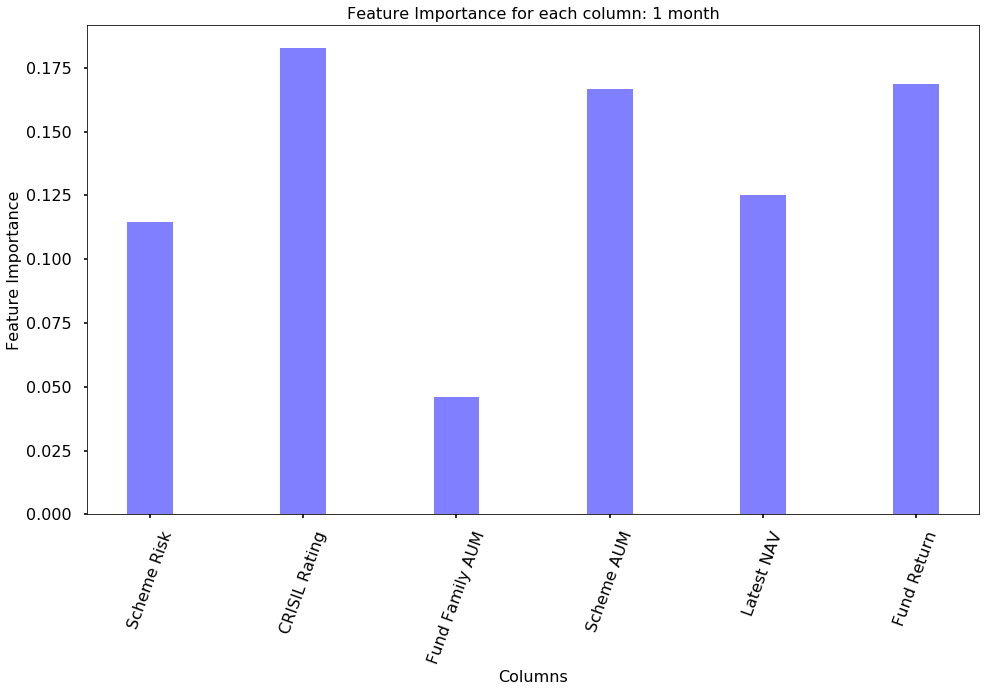

In [52]:
# 1 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_1m, [6, 7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

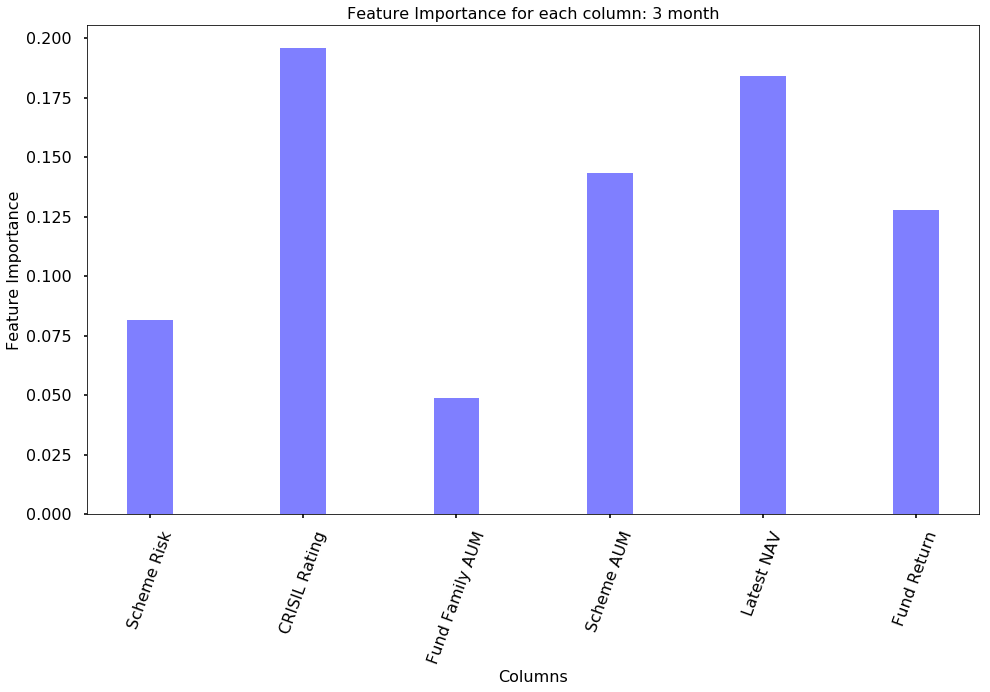

In [53]:
# 3 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_3m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

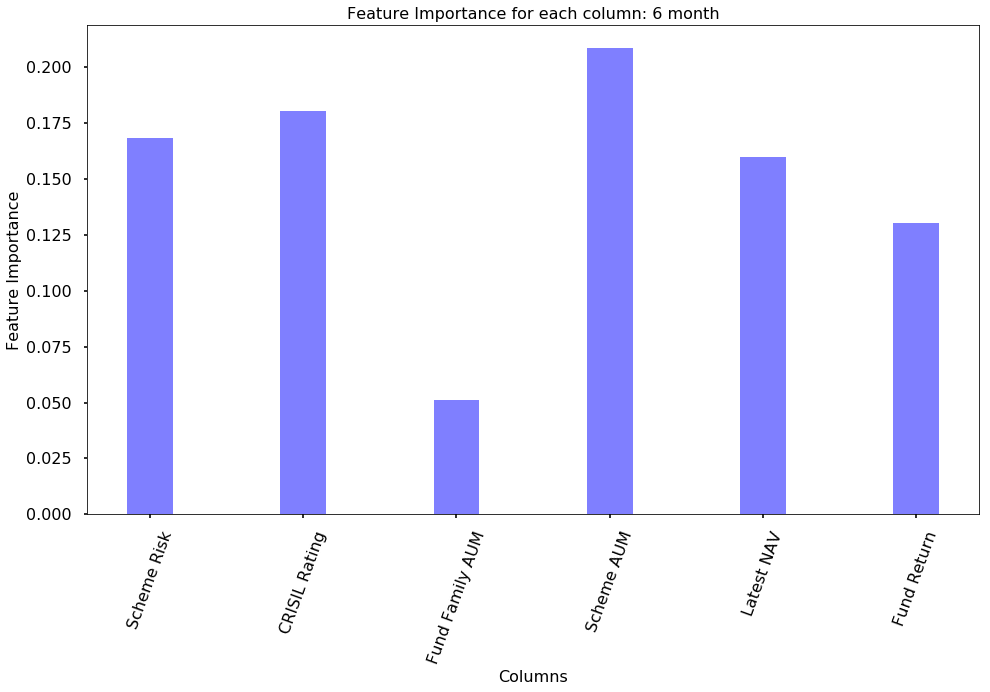

In [54]:
# 6 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_6m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 6 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

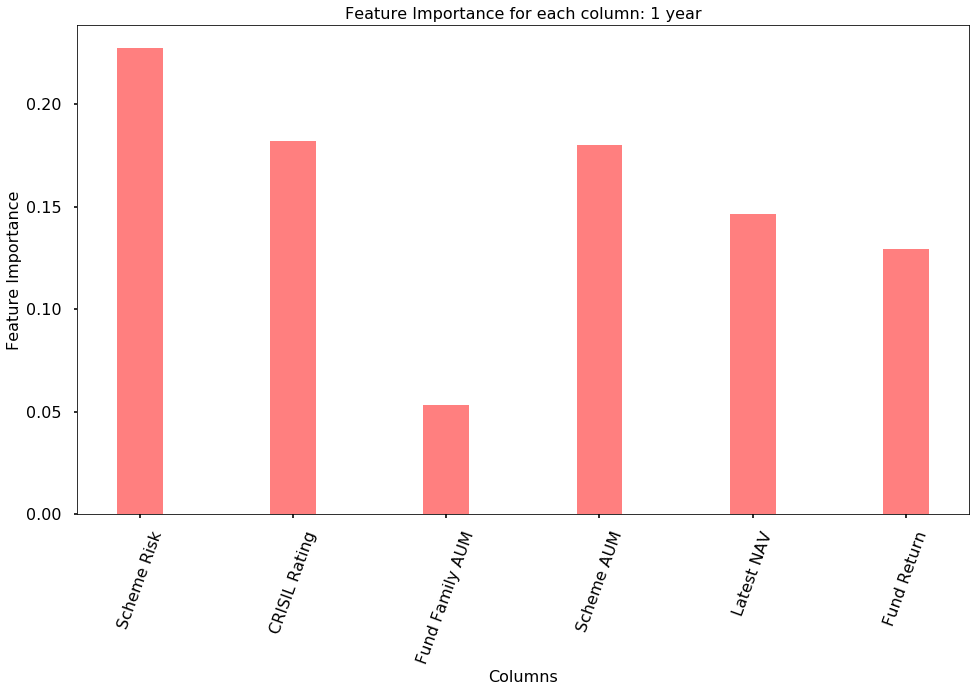

In [55]:
# 1 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_1yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='r',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

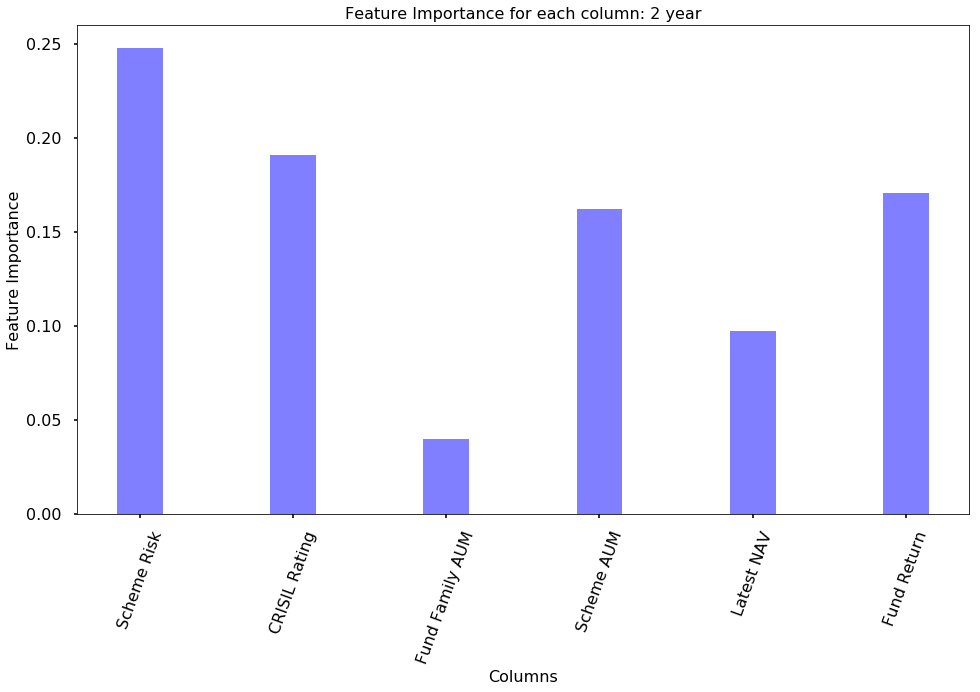

In [56]:
# 2 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_2yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 2 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

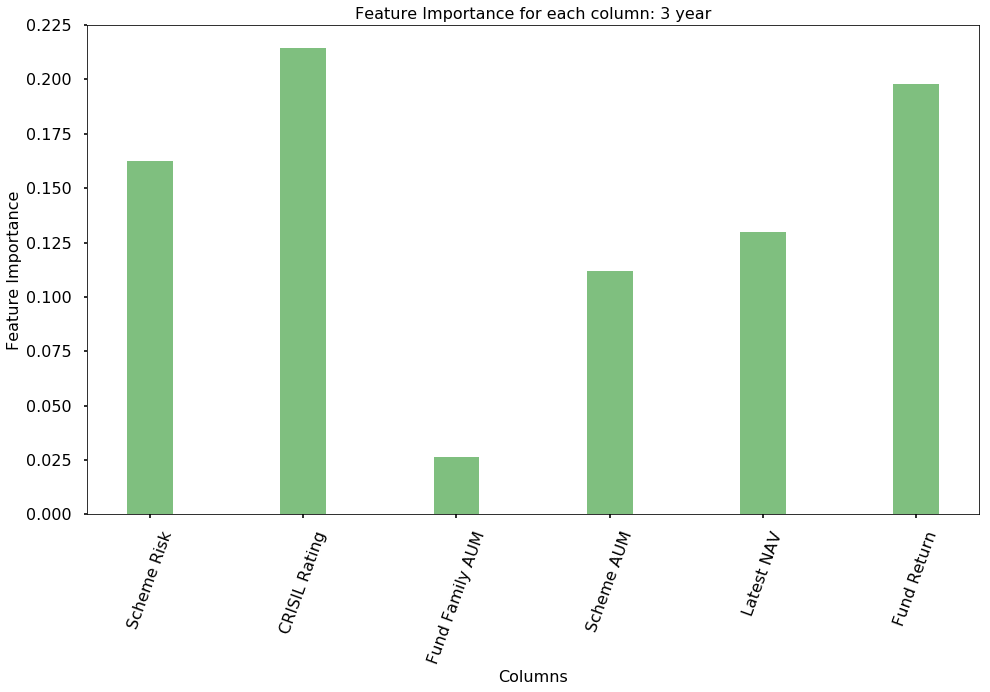

In [57]:
# 3 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_3yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='g',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

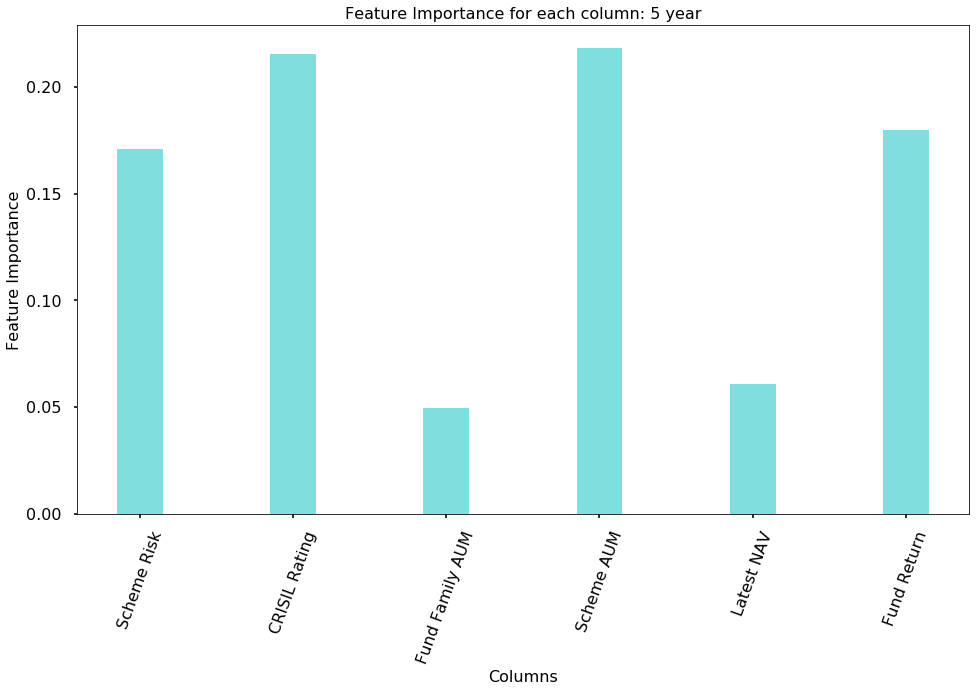

In [58]:
# 5 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_5yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='c',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 5 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

In [59]:
##
# Predict good and bad fund based on Random Forest Classification
##
Yp_1wk_predicted = clfe_1wk.predict( Xv_1wk )
Yp_1m_predicted = clfe_1m.predict( Xv_1m )
Yp_3m_predicted = clfe_3m.predict( Xv_3m )
Yp_6m_predicted = clfe_6m.predict( Xv_6m )
Yp_1yr_predicted = clfe_1yr.predict( Xv_1yr )
Yp_2yr_predicted = clfe_2yr.predict( Xv_2yr )
Yp_3yr_predicted = clfe_3yr.predict( Xv_3yr )
Yp_5yr_predicted = clfe_5yr.predict( Xv_5yr )

In [66]:
##
# Model Evaluation: Classification Score
##
clfe_1m_score = clfe_1m.score(Xv_1m[1000:, :], Yp_1m[1000:], sample_weight=None)
clfe_3m_score = clfe_3m.score(Xv_3m[1000:, :], Yp_3m[1000:], sample_weight=None)
clfe_6m_score = clfe_6m.score(Xv_6m[1000:, :], Yp_6m[1000:], sample_weight=None)
clfe_1yr_score = clfe_1yr.score(Xv_1yr[1000:, :], Yp_1yr[1000:], sample_weight=None)
clfe_2yr_score = clfe_2yr.score(Xv_2yr[1000:, :], Yp_2yr[1000:], sample_weight=None)
clfe_3yr_score = clfe_3yr.score(Xv_3yr[1000:, :], Yp_3yr[1000:], sample_weight=None)
clfe_5yr_score = clfe_5yr.score(Xv_5yr[1000:, :], Yp_5yr[1000:], sample_weight=None)


In [67]:
print('Timeframe: {0}\nScore: {1}\n'.format('1m', clfe_1m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3m', clfe_3m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('6m', clfe_6m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('1yr', clfe_1yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('2yr', clfe_2yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3yr', clfe_3yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('5yr', clfe_5yr_score) )

Timeframe: 1m
Score: 0.933497536946

Timeframe: 3m
Score: 0.928571428571

Timeframe: 6m
Score: 0.940886699507

Timeframe: 1yr
Score: 0.940886699507

Timeframe: 2yr
Score: 0.940886699507

Timeframe: 3yr
Score: 0.933497536946

Timeframe: 5yr
Score: 0.931034482759



In [81]:
# Demonstrate class imbalance

# Print the number of good samples
print( sum(Yp_1m[1000:]), sum(Yp_3m), sum(Yp_6m), sum(Yp_1yr), sum(Yp_2yr), sum(Yp_3yr), sum(Yp_5yr))

# Print the number of total samples
print( len(Yp_1m[1000:]), len(Yp_3m), len(Yp_6m), len(Yp_1yr), len(Yp_2yr), len(Yp_3yr), len(Yp_5yr))

(31.0, 103.0, 100.0, 97.0, 96.0, 102.0, 106.0)
(406, 1406, 1406, 1406, 1406, 1406, 1406)


In [61]:
## 
# List of good funds for each time frame
## 
recco_funds_1m = [ f_schemes[k] for (k, v) in enumerate( Yp_1m_predicted ) if v == 1.0 ]
recco_funds_3m = [ f_schemes[k] for (k, v) in enumerate( Yp_3m_predicted ) if v == 1.0 ]
recco_funds_6m = [ f_schemes[k] for (k, v) in enumerate( Yp_6m_predicted ) if v == 1.0 ]
recco_funds_1yr = [ f_schemes[k] for (k, v) in enumerate( Yp_1yr_predicted ) if v == 1.0 ]
recco_funds_2yr = [ f_schemes[k] for (k, v) in enumerate( Yp_2yr_predicted ) if v == 1.0 ]
recco_funds_3yr = [ f_schemes[k] for (k, v) in enumerate( Yp_3yr_predicted ) if v == 1.0 ]
recco_funds_5yr = [ f_schemes[k] for (k, v) in enumerate( Yp_5yr_predicted ) if v == 1.0 ]



In [62]:
recco_funds_1m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_1m]

recco_funds_3m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_3m]

recco_funds_6m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_6m]

recco_funds_1yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_1yr]

recco_funds_2yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_2yr]

recco_funds_3yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_3yr]

recco_funds_5yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5yr' ], fund[ 'sch_url' ] ] for fund in recco_funds_5yr]


In [80]:
    recco_funds_1m_sort.sort(key = lambda x: x[1], reverse=True)
    recco_funds_3m_sort.sort(key = lambda x: x[2], reverse=True)
    recco_funds_6m_sort.sort(key = lambda x: x[3], reverse=True)
    recco_funds_1yr_sort.sort(key = lambda x: x[4], reverse=True)
    recco_funds_2yr_sort.sort(key = lambda x: x[5], reverse=True)
    recco_funds_3yr_sort.sort(key = lambda x: x[6], reverse=True)
    recco_funds_5yr_sort.sort(key = lambda x: x[7], reverse=True)

    print( '## Top 5 funds for a timeframe of 1 month: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_1m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 months: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_3m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 6 months: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_6m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 1 year: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_1yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 2 years: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_2yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 years: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_3yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 5 years: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)')
    print( recco_funds_5yr_sort[:5] )

## Top 5 funds for a timeframe of 1 month: (Name, Returns (1m, 3m, 6m, 1yr, 2yr, 3yr, 5yr), URL)
[[u'HDFC Infrastructure - Direct (G)', 7.03, 6.44, 15.53, -2.83, -9.79, 18.96, 22.76, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-infrastructure-fund-direct-plan/MHD1155'], [u'HDFC Infrastructure Fund (G)', 6.96, 6.26, 15.13, -3.6, -11.23, 16.15, 17.36, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-infrastructure-fund/MHD283'], [u'SBI Blue Chip Fund - Direct (G)', 4.47, 8.59, 12.19, 6.11, 16.81, 38.74, 95.48, 'http://www.moneycontrol.com/mutual-funds/nav/sbi-blue-chip-fund-direct-plan/MSB532'], [u'SBI Blue Chip Fund (G)', 4.41, 8.44, 11.79, 5.21, 14.5, 34.52, 86.02, 'http://www.moneycontrol.com/mutual-funds/nav/sbi-blue-chip-fund/MSB079'], [u'Reliance Vision Fund - Direct (D)', 4.01, 7.6, 8.61, 0.82, 2.45, 25.84, 53.69, 'http://www.moneycontrol.com/mutual-funds/nav/reliance-vision-fund-direct-plan/MRC945']]
## Top 5 funds for a timeframe of 3 months: (Name, Returns (1m, 3m, 6m, 